In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader,TensorDataset
import matplotlib.pyplot as plt
from radam import RAdam

In [6]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label


In [77]:
class EEGNet(nn.Module):
    def __init__(self,activation):
        super(EEGNet, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=(1,51),padding=(0,25),bias=False),
            nn.BatchNorm2d(16))
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),groups=16,bias=False),
            nn.BatchNorm2d(32),
            activation,
            nn.AvgPool2d(kernel_size=(1,4)),
            nn.Dropout(0.25)
        )
        self.separableConv=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),padding=(0,7),bias=False),
            nn.BatchNorm2d(32),
            activation,
            nn.AvgPool2d(kernel_size=(1,8)),
            nn.Dropout(0.25)
        )
        self.classify=nn.Sequential(
            nn.Linear(736,2),
        )
    def forward(self,input):
        x=self.firstConv(input)
        x=self.depthwiseConv(x)
        x=self.separableConv(x)
        x = x.view(x.size(0), -1)
        return self.classify(x)

In [140]:
class DeepConvNet(nn.Module):
    def __init__(self,activation):
        super(DeepConvNet, self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(1,25,kernel_size=(1,5)),
            nn.Conv2d(25,25,kernel_size=(2,1)),
            nn.BatchNorm2d(25,eps=1e-5,momentum=0.1),
            activation,
            nn.MaxPool2d((1,2)),
            nn.Dropout(0.5),
            nn.Conv2d(25,50,kernel_size=(1,5)),
            nn.BatchNorm2d(50,eps=1e-5,momentum=0.1),
            activation,
            nn.MaxPool2d((1,2)),
            nn.Dropout(0.5),
            nn.Conv2d(50,100,kernel_size=(1,5)),
            nn.BatchNorm2d(100,eps=1e-5,momentum=0.1),
            activation,
            nn.MaxPool2d((1,2)),
            nn.Dropout(0.5),
            nn.Conv2d(100,200,kernel_size=(1,5)),
            nn.BatchNorm2d(200,eps=1e-5,momentum=0.1),
            activation,
            nn.MaxPool2d((1,2)),
            nn.Dropout(0.5),            
        )
        self.classify=nn.Sequential(
            nn.Linear(8600,2),
        )
    def forward(self,input):
        x=self.main(input)
        x=x.view(x.size(0),-1)
        return self.classify(x)

In [161]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:',device)
train_data,train_label,test_data,test_label=read_bci_data()
train_data=torch.tensor(train_data).float().cuda()
train_label=torch.tensor(train_label).long().cuda()
test_data=torch.tensor(test_data,device=device).float()
test_label=torch.tensor(test_label,device=device).long()

# Parameters
epochs = 300
lr = 0.001
batch_size=256
weight_decay=0.001
criterion = nn.CrossEntropyLoss()

trainset=TensorDataset(train_data, train_label)
train_loader=DataLoader(dataset=trainset,batch_size=batch_size,shuffle=True)
test_set=TensorDataset(test_data,test_label)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

device: cuda:0
(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [159]:
def train(net,optimizer):
    train_acc=[]
    test_acc=[]
    train_loss=[]
    for epoch in range(epochs):
        # Train
        net.train()
        running_loss=0.0
        correct=0.0
        for times,data in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, labels = data[0], data[1]
            outputs = net(inputs)
            _, predict = torch.max(outputs.data, 1)
            correct+=(predict==labels).sum().item()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
           
        train_acc.append(correct/train_label.size(0)*100)
        train_loss.append(running_loss)
        
        # Test
        with torch.no_grad():
            net.eval()
            correct=0.0
            for data in test_loader:
                inputs, labels = data
                outputs=net(inputs)
                _, predict = torch.max(outputs.data, 1)
                correct+=(predict==labels).sum().item()
            test_acc.append(correct/test_label.size(0)*100)
            
    return train_acc,train_loss,test_acc

In [54]:
def plot_loss(loss,title):
    plt.title(title + ' training loss')
    plt.plot(range(epochs),loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

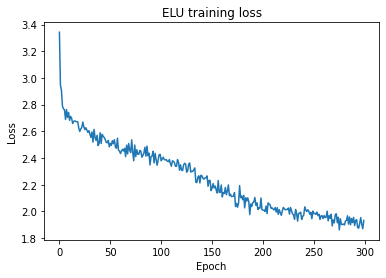

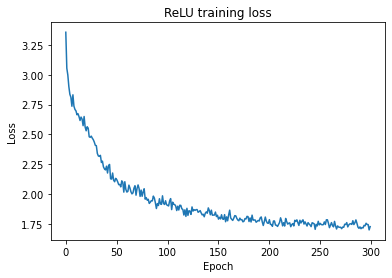

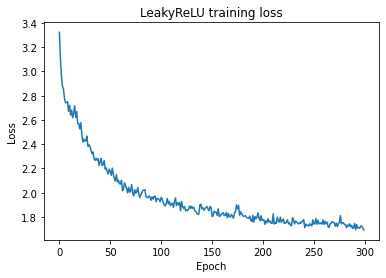

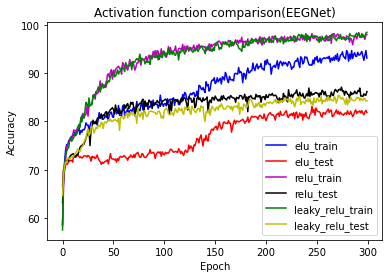

In [165]:
elu_EEGNet=ELUNet(nn.ELU()).to(device)
optimizer = optim.Adam(elu_EEGNet.parameters(),lr=lr,weight_decay=weight_decay)
elu_train_acc,train_loss,elu_test_acc=train(elu_EEGNet,optimizer)
plot_loss(train_loss,'ELU')

relu_EEGNet=ELUNet(nn.ReLU()).to(device)
optimizer = optim.Adam(relu_EEGNet.parameters(),lr=lr, weight_decay=weight_decay)
relu_train_acc,train_loss,relu_test_acc=train(relu_EEGNet,optimizer)
plot_loss(train_loss,'ReLU')

leaky_relu_EEGNet=ELUNet(nn.LeakyReLU()).to(device)
optimizer = optim.Adam(leaky_relu_EEGNet.parameters(),lr=lr, weight_decay=weight_decay)
leaky_relu_train_acc,train_loss,leaky_relu_test_acc=train(leaky_relu_EEGNet,optimizer)
plot_loss(train_loss,'LeakyReLU')

#畫圖
plt.title('Activation function comparison(EEGNet)')
plt.plot(range(epochs),elu_train_acc,color='b',label='elu_train')
plt.plot(range(epochs),elu_test_acc,color='r',label='elu_test')
plt.plot(range(epochs),relu_train_acc,color='m',label='relu_train')
plt.plot(range(epochs),relu_test_acc,color='k',label='relu_test')
plt.plot(range(epochs),leaky_relu_train_acc,color='g',label='leaky_relu_train')
plt.plot(range(epochs),leaky_relu_test_acc,color='y',label='leaky_relu_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [166]:
#顯示最高正確率
print('EGGNet')
print('Relu :{:.2f}%' .format(max(relu_test_acc)))
print('Leaky Relu :{:.2f}%' .format(max(leaky_relu_test_acc)))
print('Elu :{:.2f}%' .format(max(elu_test_acc)))

EGGNet
Relu :87.13%
Leaky Relu :85.46%
Elu :83.15%


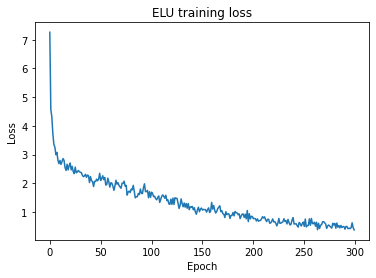

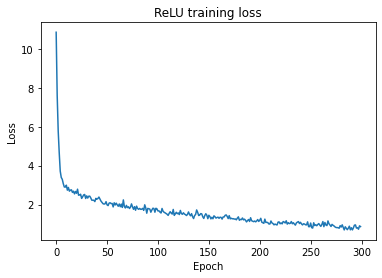

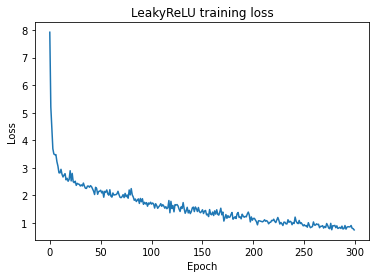

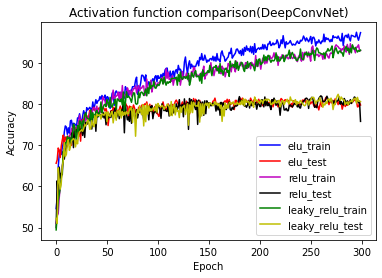

In [167]:
elu_deep_conv=DeepConvNet(nn.ELU()).to(device)
optimizer=optim.Adam(elu_deep_conv.parameters(),lr=lr, weight_decay=weight_decay)
elu_train_acc,train_loss,elu_test_acc=train(elu_deep_conv,optimizer)
plot_loss(train_loss,'ELU')

relu_deep_conv=DeepConvNet(nn.ReLU()).cuda()
optimizer=optim.Adam(relu_deep_conv.parameters(),lr=lr, weight_decay=weight_decay)
relu_train_acc,train_loss,relu_test_acc=train(relu_deep_conv,optimizer)
plot_loss(train_loss,'ReLU')

leaky_relu_deep_conv=DeepConvNet(nn.LeakyReLU()).cuda()
optimizer=optim.Adam(leaky_relu_deep_conv.parameters(),lr=lr, weight_decay=weight_decay)
leaky_relu_train_acc,train_loss,leaky_relu_test_acc=train(leaky_relu_deep_conv,optimizer)
plot_loss(train_loss,'LeakyReLU')
                               
#畫圖
plt.title('Activation function comparison(DeepConvNet)')
plt.plot(range(epochs),elu_train_acc,color='b',label='elu_train')
plt.plot(range(epochs),elu_test_acc,color='r',label='elu_test')
plt.plot(range(epochs),relu_train_acc,color='m',label='relu_train')
plt.plot(range(epochs),relu_test_acc,color='k',label='relu_test')
plt.plot(range(epochs),leaky_relu_train_acc,color='g',label='leaky_relu_train')
plt.plot(range(epochs),leaky_relu_test_acc,color='y',label='leaky_relu_test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [168]:
#顯示最高正確率
print('DeepConvNet')
print('Relu :{:.2f}%' .format(max(relu_test_acc)))
print('Leaky Relu :{:.2f}%' .format(max(leaky_relu_test_acc)))
print('Elu :{:.2f}%' .format(max(elu_test_acc)))

DeepConvNet
Relu :82.04%
Leaky Relu :82.41%
Elu :81.67%
